In [41]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import tqdm

### Actor网络输出每一个动作的概率

In [42]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = self.fc2(F.relu(self.fc1(x)))
        return F.softmax(x, dim = 1)


### Critic网络给定状态和动作，输出该状态下选择动作$a$的$Q$值

In [43]:
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

In [44]:
class Actor_Critic:
    def __init__(self, state_dim, hidden_dim, action_dim, lr_actor, lr_critic, gamma):
        self.gamma = gamma
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.actor = Actor(state_dim, hidden_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim, hidden_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = lr_critic)


    def take_action(self, state):
        # state = torch.tensor(state, dtype = torch.float)
        state = torch.tensor(state[np.newaxis, :]).to(self.device)
        probs = self.actor(state)
        action_dict = torch.distributions.Categorical(probs)
        action = action_dict.sample().item()
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict["state"], dtype = torch.float).to(self.device)
        actions = torch.tensor(transition_dict["action"]).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict["reward"]).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict["next_state"], dtype = torch.float).to(self.device)
        dones = torch.tensor(transition_dict["done"]).view(-1, 1).to(self.device)

        # 当前时刻状态的估计值 下一时刻状态的估计值
        q_predict = self.critic(states)
        q_target = rewards + self.gamma * self.critic(next_states) * torch.logical_not(dones)
        # print(q_predict.device, q_target.device)
        
        q_delta = q_target - q_predict

        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * q_delta.detach())
        critic_loss = torch.mean(F.mse_loss(q_predict, q_target.detach()))

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        

In [45]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


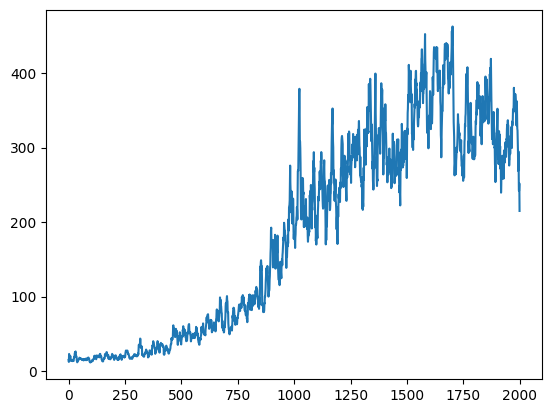

In [46]:
num_episodes = 2000  # 总迭代次数
gamma = 0.9  # 折扣因子
actor_lr = 1e-3  # 策略网络的学习率
critic_lr = 1e-2  # 价值网络的学习率
n_hiddens = 16  # 隐含层神经元个数
env_name = 'CartPole-v1'
history = []  # 保存每个回合的return

env = gym.make(env_name)
n_states = env.observation_space.shape[0]  # 状态数 4
n_actions = env.action_space.n  # 动作数 2

agent = Actor_Critic(n_states, n_hiddens, n_actions, actor_lr, critic_lr, gamma)

random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

# --------------------------------train-------------------------------------------#

for i in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward_total = 0
    transition_dict = {
        "state" : [],
        "action" : [],
        "reward" : [],
        "next_state" : [],
        "done" : []
    }
    while not done:
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)

        episode_reward_total += reward

        transition_dict['state'].append(state)
        transition_dict['action'].append(action)
        transition_dict['reward'].append(reward)
        transition_dict['next_state'].append(next_state)
        transition_dict['done'].append(done)

        state = next_state
        
    agent.update(transition_dict)
    
    history.append(episode_reward_total)
    if episode_reward_total >= 1000:
        break

history = moving_average(history, 9)
plt.plot(history)
plt.show()

In [1]:
with torch.no_grad():
    state = env.reset()
    done = False
    reward_sum = 0
    while not done:
        env.render()
        action = agent.take_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        reward_sum += reward

print(f'reward is {reward_sum}')
env.close()

NameError: name 'torch' is not defined